# Overview

**Workflow:**

1. Load the data
2. Clean it:
    * get rid of missing values
    * change column names
    * change dtypes for better memory use
3. Analyze it

**Data description:**

Outpatient prescription drugs paid for by state medicaid agencies. I'm guessing that each entry represents a hospital in a state.

**Notes:**

Some stats (appx):

* U.S. population: 325 million.
* 73 million people are on medicaid, that's just over 1/5th of the population.
* 40 million are on medicare.
* 8% of people are not insured.
* 37.7% are on government healthcare, 67% are on private health coverage.
* Out of private, employer based accounts for 56%.

Medicaid is a rather small sample of the population, it would be interesting to see a larger subset.

*Demographics of people on Medicaid:*

- Medicaid and CHIP participants are among the most vulnerable members of the U.S. population.

![alt text](medicaidstatistics.png)

* No one knows why so many kids have asthma! Interesting!

**Sources**

- https://www.census.gov/library/publications/2018/demo/p60-264.html
- https://data.medicaid.gov/State-Drug-Utilization/State-Drug-Utilization-Data-2017/3v5r-x5x9
- https://www.prb.org/majority-of-people-covered-by-medicaid-and-similar-programs/
- https://www.verywellhealth.com/the-30-most-prescribed-drugs-in-pediatrics-2633435

**To do:**

- Figure out why the most common drugs are on there.
- Visualize the most commonly taken drugs.
- Do some cool things in plotly.

# Load drug data with selected columns and good memory usage

In [275]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format='retina'

In [166]:
# Check available features

df2007 = pd.read_csv('State_Drug_Utilization_Data_2007.csv', nrows=20)
df2007.head()

,Utilization Type,State,Labeler Code,Product Code,Package Size,Year,Quarter,Product Name,Units Reimbursed,Suppression Used,Number of Prescriptions,Total Amount Reimbursed,Medicaid Amount Reimbursed,Non Medicaid Amount Reimbursed,Quarter Begin,Quarter Begin Date,Latitude,Longitude,Location,NDC
0,FFSU,MI,904,12,59,2007,2,ALLERGY,1516.0,False,20.0,52.86,0.00,0.0,4/1,04/01/2007,43.3504,-84.5603,"(43.3504, -84.5603)",904001259
1,FFSU,NV,58177,329,4,2007,4,NATATAB FA,NaN,True,NaN,NaN,NaN,NaN,10/1,10/01/2007,38.4199,-117.1219,"(38.4199, -117.1219)",58177032904
2,FFSU,MT,591,388,1,2007,2,HYDROCODON,NaN,True,NaN,NaN,NaN,NaN,4/1,04/01/2007,46.9048,-110.3261,"(46.9048, -110.3261)",591038801
3,FFSU,VA,54092,387,1,2007,4,ADDERALL X,86685.0,False,2182.0,360795.86,335550.96,25244.9,10/1,10/01/2007,37.7680,-78.2057,"(37.768, -78.2057)",54092038701
4,FFSU,CA,603,3740,21,2007,2,FUROSEMIDE,10547.0,False,213.0,2087.53,2087.53,0.0,4/1,04/01/2007,36.1700,-119.7462,"(36.17, -119.7462)",603374021


In [2]:
# Load state drug data for 2008 - 2018

columns = ['State', 'Year', 'Product Name', 'Quarter', 'Number of Prescriptions']
filenames = ['State_Drug_Utilization_Data_' + str(i) + '.csv' for i in range(2007, 2018)]

df = pd.concat(pd.read_csv(filename, usecols=columns) 
               for filename in filenames)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39527716 entries, 0 to 4725198
Data columns (total 5 columns):
State                      object
Year                       int64
Quarter                    int64
Product Name               object
Number of Prescriptions    float64
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ GB


In [5]:
df.sample(5)

,State,Year,Quarter,Product Name,Number of Prescriptions
1658516,VT,2009,3,IBUPROFEN,NaN
2444674,NM,2013,3,PACLITAXEL,34.0
1676090,MO,2012,1,VANCOMYCIN,NaN
577432,FL,2012,1,CEPHALEXIN,53.0
3390133,HI,2016,3,OMNIPAQUE,NaN


In [3]:
# Convert non-numeric columns to category to save memory

df[['State', 'Product Name', 'Quarter', 
    'Number of Prescriptions']] = df[['State','Product Name', 
                                      'Quarter','Number of Prescriptions']].astype('category')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39527716 entries, 0 to 4725198
Data columns (total 5 columns):
State                      category
Year                       int64
Quarter                    category
Product Name               category
Number of Prescriptions    category
dtypes: category(4), int64(1)
memory usage: 984.6 MB


In [8]:
df.describe(include='all')

,State,Year,Quarter,Product Name,Number of Prescriptions
count,39527716,3.952772e+07,39527716.0,39520556,19480099.0
unique,52,NaN,4.0,33927,67594.0
top,XX,NaN,4.0,LISINOPRIL,15.0
freq,2371072,NaN,10068762.0,464392,360957.0
mean,NaN,2.012807e+03,NaN,NaN,NaN
std,NaN,2.995609e+00,NaN,NaN,NaN
min,NaN,2.007000e+03,NaN,NaN,NaN
25%,NaN,2.011000e+03,NaN,NaN,NaN
50%,NaN,2.013000e+03,NaN,NaN,NaN
75%,NaN,2.015000e+03,NaN,NaN,NaN


In [9]:
# TODO:
# 2. Do some frequency count plots
# 3. See which states use which drugs
# 4. Come up with some more questions

# Take care of the missing values in Product Name

In [5]:
# We have 3311 ?'s and 5854 NaNs

print((df['Product Name'] == '?').sum())
print(df.isna().sum())

# Replace ? with nan

df = df.replace('?', np.NaN)

3404
State                             0
Year                              0
Quarter                           0
Product Name                   7160
Number of Prescriptions    20047617
dtype: int64


In [6]:
df.isna().sum()

State                             0
Year                              0
Quarter                           0
Product Name                  10564
Number of Prescriptions    20047617
dtype: int64

In [7]:
# Just drop the nans, there aren't very many of them

df = df.dropna(subset=['Product Name'])
df.isna().sum()

State                             0
Year                              0
Quarter                           0
Product Name                      0
Number of Prescriptions    20038088
dtype: int64

In [8]:
# XX are aggregated entries, remove them

df = df[df.State != 'XX']


# What drugs are people on?

In this section, we will see the types of drugs people are taking in the U.S. by state, year, and time of year.

In [13]:
# Pearson correlation only shows numeric

df.corr()

,Year
Year,1.0


In [44]:
# Factorize into numbers for non-numeric correlations

df.apply(lambda x: x.factorize()[0]).corr()

,State,Year,Quarter,Product Name,Number of Prescriptions
State,1.000000,-0.008239,0.002205,-0.017380,-0.015266
Year,-0.008239,1.000000,0.004258,0.229291,0.007148
Quarter,0.002205,0.004258,1.000000,-0.006106,-0.001100
Product Name,-0.017380,0.229291,-0.006106,1.000000,-0.044218
Number of Prescriptions,-0.015266,0.007148,-0.001100,-0.044218,1.000000


In [16]:
df.sort_values(by='Number of Prescriptions', ascending=False).head(5)

,State,Year,Quarter,Product Name,Number of Prescriptions
432570,SD,2007,3,SPIRONOLAC,990000.0
1631471,SD,2007,3,STRATTERA,990000.0
1002654,SD,2007,3,FOSINOPRIL,990000.0
2048466,SD,2007,3,BENZTROPIN,990000.0
1887649,SD,2007,3,GLYBURIDE/,990000.0


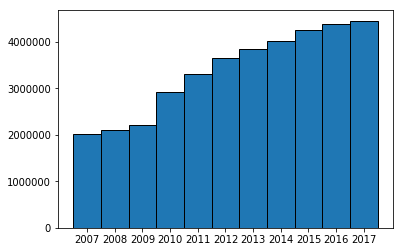

In [72]:
# Plot number of drugs being prescribed in the past 10 years

ig, ax = plt.subplots(1,1)
bins = np.arange(2007,2019)
ax.hist(df['Year'], bins=bins, align='left', ec='black')
ax.set_xticks(range(2007,2018));

# Number 

In [77]:
(df['Product Name'] == 'ALPRAZOLAM').value_counts()

False    36958190
True       191055
Name: Product Name, dtype: int64

In [43]:
# 7110 Entries for alprazolam
# this tell us that 7110 hospitals prescribed alprazolam from 2007 - 2017

(df[df['Product Name'] == 'ALPRAZOLAM']['State'] == 'CA').value_counts()

False    183945
True       7110
Name: State, dtype: int64

In [67]:
# Get a rough estimate of the # of prescriptions of Alpraz

# ca_df = df[(df['State'] == 'CA') & (df['Year'] == 2017)]
ca_df = df[df['State'] == 'CA']
ca_df[ca_df['Product Name'] == 'ALPRAZOLAM']['Number of Prescriptions'].dropna().astype('int').sum()

# 2,620,094 Xanax prescriptions in the past 10 years
# 454,817 in 2017

2620094

In [114]:
# Let's see the number of prescriptions by state

df_p = df[df['Number of Prescriptions'].notnull()]
df_p['Number of Prescriptions'] = df_p['Number of Prescriptions'].astype('int')
df_p.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,State,Year,Quarter,Product Name,Number of Prescriptions
0,MI,2007,2,ALLERGY,20
3,VA,2007,4,ADDERALL X,2182
4,CA,2007,2,FUROSEMIDE,213
7,GA,2007,2,ASPIRIN EC,1196
9,KY,2007,4,CARVEDILOL,102


In [141]:
# Sum prescriptions for each state

# df_s = df_p.sample(100)
pv = df_p.pivot_table(values='Number of Prescriptions', index='State', columns='Year', aggfunc=np.sum)
pv['Totals'] = pv.sum(axis=1)

In [152]:
pv

Year,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,Totals
State,,,,,,,,,,,,
MI,6.015284e+06,5939927.0,6597209.0,15789141.0,20207401.0,20034040.0,20339080.0,23824796.0,27449929.0,31249189.0,31437566.0,2.088836e+08
VA,3.911205e+06,4035983.0,4451442.0,5245006.0,10287523.0,10812711.0,11207378.0,10938647.0,10699848.0,11069048.0,10584494.0,9.324328e+07
CA,3.324254e+07,32709973.0,33876679.0,47484957.0,54922238.0,52184950.0,55189359.0,69622307.0,92910248.0,99175952.0,102320837.0,6.736400e+08
GA,6.218345e+06,6748069.0,7251874.0,11351149.0,13736188.0,16322713.0,16445996.0,16691847.0,16905060.0,16712454.0,17166415.0,1.455501e+08
KY,9.569844e+06,9701283.0,10413442.0,12321084.0,13299885.0,12884643.0,12039690.0,14814713.0,17473144.0,18368160.0,17813323.0,1.486992e+08
NJ,4.956174e+06,5465737.0,5495048.0,9127501.0,10583525.0,13577737.0,12347236.0,15643611.0,19416630.0,23331897.0,20317549.0,1.402626e+08
NC,1.304027e+07,14351953.0,15597138.0,16107806.0,16198633.0,16371258.0,15971071.0,16781514.0,16863580.0,16969943.0,16830684.0,1.750839e+08
OR,1.705752e+06,1652967.0,1806479.0,3917179.0,6069443.0,5349193.0,6132972.0,8445760.0,10048537.0,9942009.0,10554852.0,6.562514e+07
IN,5.038073e+06,4988902.0,5248996.0,12085864.0,11607717.0,12571502.0,11882283.0,11769464.0,13406037.0,17207302.0,16574743.0,1.223809e+08


In [252]:
# Discovering new things: no data for Arizona for 2007, 2008, 2009
# but why?

# starts with 2010...checked the actual csv, it's missing!
# they started recording the data in 2010

# Let's infer the values based on comparable states for those years
# AZ population is closest to massachussets so well fill in values from massachussets

values = {2007: 7607295.0, 2008: 7884396.0, 2009: 7719774.0}
pv = pv.fillna(value=values)

# Rerun the pivot table aggregation function

pv['Totals'] = pv.sum(axis=1)

# Check that MA and AZ totals are close

print(pv[pv.index == 'MA']['Totals'])
print(pv[pv.index == 'AZ']['Totals'])

State
MA    530987748.0
Name: Totals, dtype: float64
State
AZ    531092823.0
Name: Totals, dtype: float64


In [254]:
# Number of prescriptions by state 2007 - 2017
# Interactive chart that shows

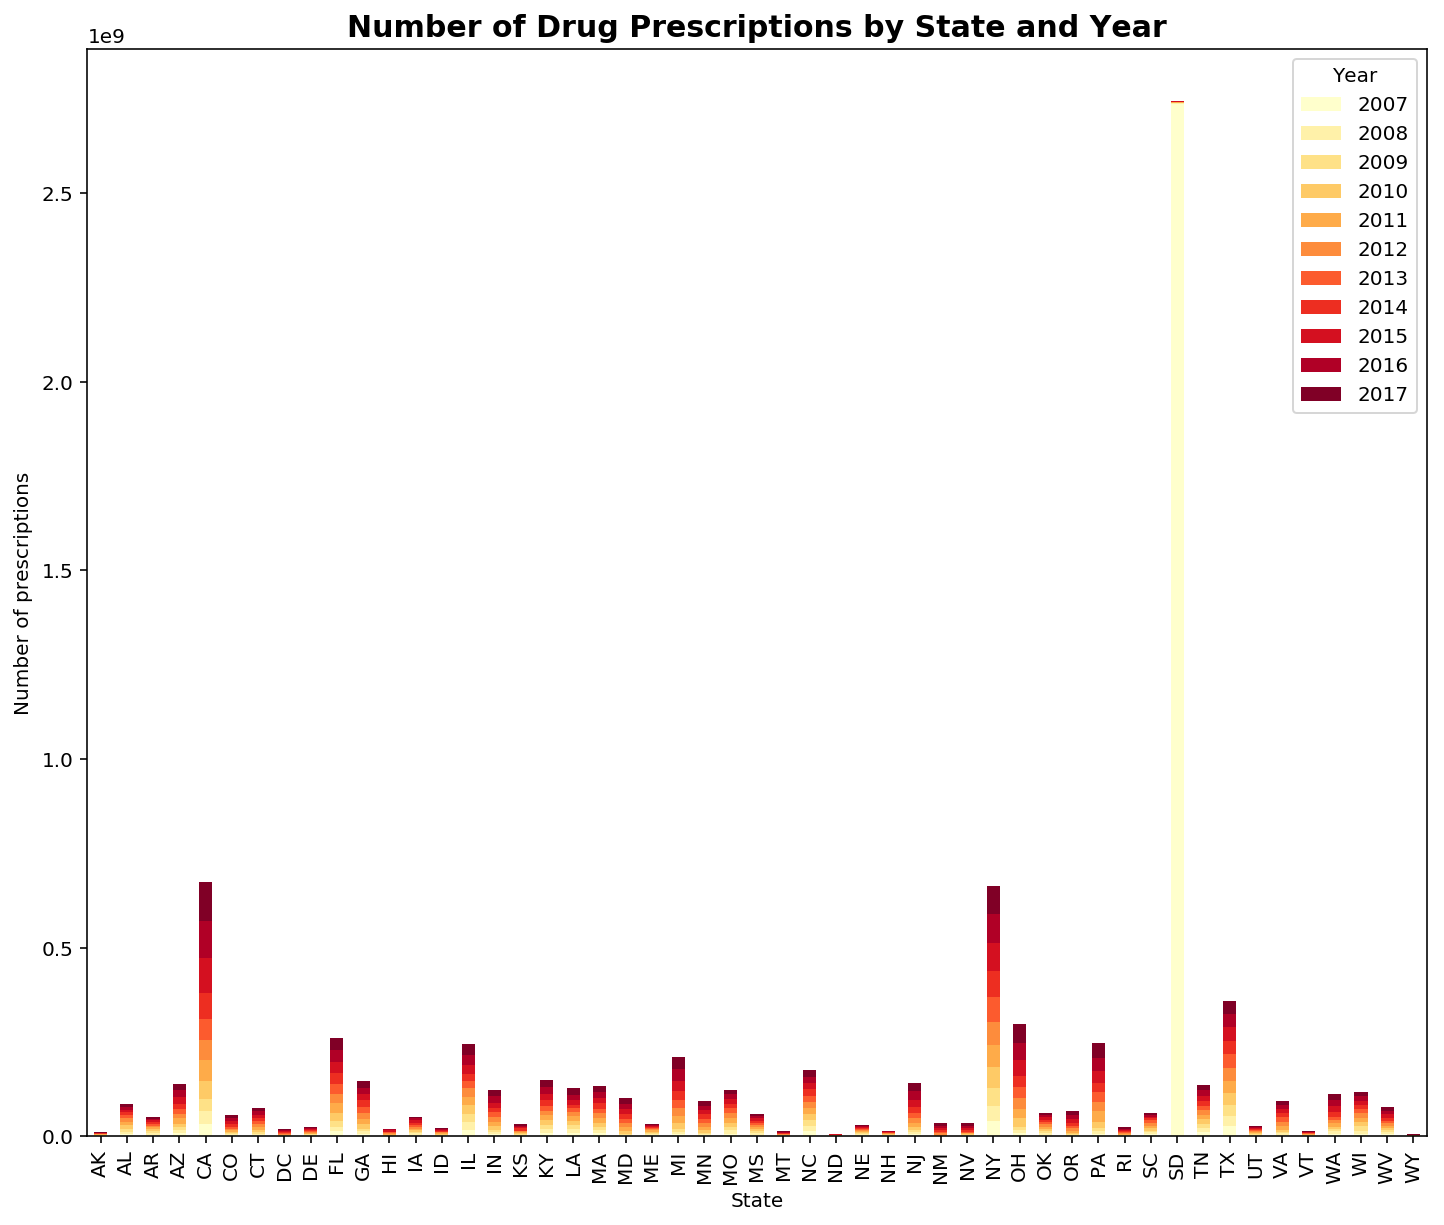

In [310]:
g = pv.iloc[:,:-1].sort_values('State').plot.bar(stacked=True, figsize=(12,10), cmap="YlOrRd")
g.set_title('Number of Drug Prescriptions by State and Year', size=15, weight='bold')
plt.ylabel('Number of prescriptions');

In [312]:
# What's going on with South Dakota in 2007?

pv[pv.index == 'SD']

Year,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,Totals
State,,,,,,,,,,,,
SD,2.738040e+09,660152.0,711757.0,768313.0,628332.0,677936.0,615078.0,647673.0,793766.0,891672.0,838883.0,1.098110e+10
